In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [8]:
from models import MLP_GPINN_LambdaAdaptive
net = MLP_GPINN_LambdaAdaptive(N_layers=8, width=32, useRatioOfRatio=True, activation=nn.ELU()).to(device)

In [4]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
#train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

use_random_sdf = isinstance(train_dataset, RandomMeshSDFDataset)
points = train_dataset.points if use_random_sdf else train_dataset.pde_points
sdfs = train_dataset.sdfs if use_random_sdf else train_dataset.bc_sdfs

RandomMeshSDFDataset (10000 points)


In [11]:
from utils.optimizer import CallbackScheduler
import torch_optimizer

# Optimization
## ADA
optimizer=torch_optimizer.AdaBound(net.parameters(), lr=0.001, betas=(0.9, 0.999))
#optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    # CallbackScheduler.reduce_lr(0.2),
    # CallbackScheduler.reduce_lr(0.2),
    # CallbackScheduler.init_LBFGS(
    #     lr=1, max_iter=20, max_eval=40, 
    #     tolerance_grad=1e-5, tolerance_change=1e-9,
    #     history_size=100,
    #     line_search_fn=None
    # ),
    # CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [14]:
#torch.autograd.set_detect_anomaly(True)
max_epochs = 2500
PRINT_EVERY_EPOCH = 100
points.requires_grad_(True)
try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        y = net(points)
        loss = net.loss(y, points, points, sdfs)
        loss.backward(retain_graph=True)
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)

        if epoch % 20 == 19:
            y = net(points)
            net.adaptive_lambda(y, points, points, sdfs)
        
        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}, {net._loss_gradient_PDE:.6f}')
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.546476, 0.031390, 0.026815
#100 Loss: 0.617804, 0.030758, 0.023642
Bye bye


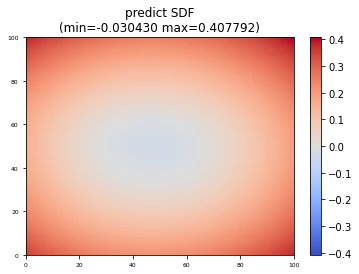

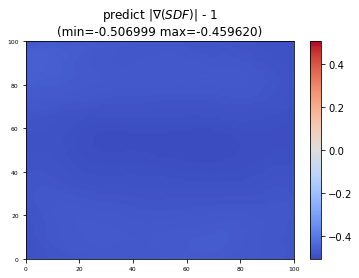

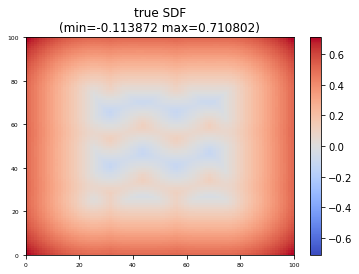

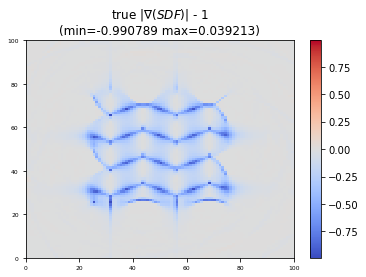

In [13]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)